In [37]:
import sys
import Topyfic
import pandas as pd
import scanpy as sc
import numpy as np
from scipy import stats
import random
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42



In [38]:
def make_unique(series):
    seen = set()
    result = []
    for item in series:
        if item in seen:
            count = 1
            while f"{item}_{count}" in seen:
                count += 1
            result.append(f"{item}_{count}")
        else:
            seen.add(item)
            result.append(item)
    return result


In [39]:
sex_palette = {'Male': 'blue', 'Female': 'pink'}
tp_palette = {'PND_04': '#e1c1da',
               'PND_10': '#f0a1e0',
               'PND_14': '#ff83f1',
               'PND_25': '#d453d7',
               'PND_36': '#ae01d7',
               'PNM_02': '#970083',
               'PNM_18': '#560085'}

tissue_palette = {'adrenal': '#ff9458',
                   'cortex': '#ffe578',
                   'hippocampus': '#967add',
                   'gastrocnemius': '#34b0d8',
                   'heart': '#ff9aaf'}

biotype_palette = {'TF': '#f62324',
                   'Chromatin_binding': '#00a300',
                   'Transcription_regulator': '#0078b8',
                   'Chromatin_organization': '#935348',
                   'MiRNA_HG': '#9b62c1',
                   'Histone_modifying_enzyme': '#f26ec4',
                   'TAF-MED': '#ff7700'}

tissues = ["adrenal", "cortex", "hippocampus", "heart", "gastrocnemius"]


# Fig. 2a-g

In [40]:
meta = pd.read_csv("../snrna/ref/enc4_mouse_metadata_fixed.csv")

# Select unique columns
meta = meta[['sample', 'timepoint', 'sex', 'tissue']].drop_duplicates()

# Convert tissue column to lowercase
meta['tissue'] = meta['tissue'].str.lower()


tissue_biotype_palette = {}
tissue_biotype_palette["TF"] = {'adrenal': '#f62324',
                                'cortex': '#f62324',
                                'hippocampus': '#f62324',
                                'gastrocnemius': '#f62324',
                                'heart': '#f62324',
                                'all_tissues': '#fba7a7',
                                'total_possible': '#fdd3d3'}

tissue_biotype_palette["Chromatin_binding"] = {'adrenal' : '#00a300',
                                   'cortex' :  '#00a300',
                                   'hippocampus' : '#00a300',
                                   'gastrocnemius' : '#00a300',
                                   'heart' : '#00a300',
                                   'all_tissues' : '#99da99',
                                   'total_possible' : '#cceccc'}

tissue_biotype_palette["Transcription_regulator"] = {'adrenal' : '#0078b8',
                                   'cortex' :  '#0078b8',
                                   'hippocampus' : '#0078b8',
                                   'gastrocnemius' : '#0078b8',
                                   'heart' : '#0078b8',
                                   'all_tissues' : '#99c9e2',
                                   'total_possible' : '#cce4f0'}

tissue_biotype_palette["Chromatin_organization"] = {'adrenal' : '#935348',
                                   'cortex' :  '#935348',
                                   'hippocampus' : '#935348',
                                   'gastrocnemius' : '#935348',
                                   'heart' : '#935348',
                                   'all_tissues' : '#d3bab5',
                                   'total_possible' : '#e9dcda'}

tissue_biotype_palette["MiRNA_HG"] = {'adrenal' : '#9b62c1',
                                   'cortex' :  '#9b62c1',
                                   'hippocampus' : '#9b62c1',
                                   'gastrocnemius' : '#9b62c1',
                                   'heart' : '#9b62c1',
                                   'all_tissues' : '#d7c0e6',
                                   'total_possible' : '#ebdff2'}

tissue_biotype_palette["Histone_modifying_enzyme"] = {'adrenal' : '#f26ec4',
                                   'cortex' :  '#f26ec4',
                                   'hippocampus' : '#f26ec4',
                                   'gastrocnemius' : '#f26ec4',
                                   'heart' : '#f26ec4',
                                   'all_tissues' : '#f9c5e7',
                                   'total_possible' : '#fce2f3'}

tissue_biotype_palette["TAF-MED"] = {'adrenal' : '#ff7700',
                                   'cortex' :  '#ff7700',
                                   'hippocampus' : '#ff7700',
                                   'gastrocnemius' : '#ff7700',
                                   'heart' : '#ff7700',
                                   'all_tissues' : '#ffc899',
                                   'total_possible' : '#ffe3cc'}



In [41]:
tpm_all_tissue = pd.read_csv("../bulk/rna/bulk_rna_tpm_postnatal_mouse.csv", index_col=0)
tpm_all_tissue['unique_name'] = make_unique(tpm_all_tissue['gene_name'])
tpm_all_tissue = tpm_all_tissue.drop(columns=['host_gene_id', 'gene_name'])

meta = meta[meta['sample'].isin(tpm_all_tissue.columns)]
sample_names = meta['sample'].tolist()
sample_names.append("unique_name")
tpm_all_tissue = tpm_all_tissue[sample_names]


In [42]:
regs = pd.read_csv("../snrna/ref/gene_display_table_7categories.csv", index_col=0)
regs['unique_name'] = make_unique(regs['gene_name'])

In [43]:
threshold = 1
all_expressed_genes = [] 

for tissue in tissues:
    meta_filt = meta[meta['tissue'] == tissue]
    sample_names = meta_filt['sample'].tolist()
    sample_names.append("unique_name")
    tpm = tpm_all_tissue[sample_names]    
    
    merged_data =  pd.merge(regs, tpm, on='unique_name', how='left')
    
    # Filter rows based on threshold using the correct variable 'merged_data'
    filtered_data = merged_data.drop(columns=['unique_name', 'gene_name', 'display_name', 'biotype', 'keep'])
    filtered_data.index = merged_data['unique_name']
    
    genes = filtered_data[filtered_data.apply(lambda row: any(row > threshold), axis=1)]
    genes = genes.index
    expressed_genes = regs[regs['unique_name'].isin(genes)]
    expressed_genes['tissue'] = tissue
    all_expressed_genes.append(expressed_genes)



In [44]:
all_expr_reg = pd.concat(all_expressed_genes, ignore_index=True)


In [45]:
desired_biotype_order = ["TF", "Chromatin_binding", "Chromatin_organization",
                         "Transcription_regulator", "MiRNA_HG", 
                         "Histone_modifying_enzyme", "TAF-MED"]
all_expr_reg['biotype'] = pd.Categorical(all_expr_reg['biotype'], categories=desired_biotype_order, ordered=True)



In [46]:
biotype_totals = {'TF': 1357, 'Chromatin_binding': 396, 'Chromatin_organization': 320,
                  'Transcription_regulator': 308, 'MiRNA_HG': 167,
                  'Histone_modifying_enzyme': 126, 'TAF-MED': 115}



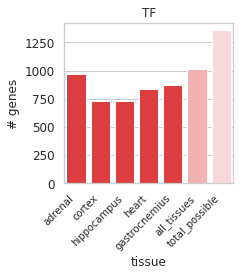

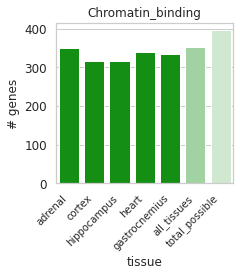

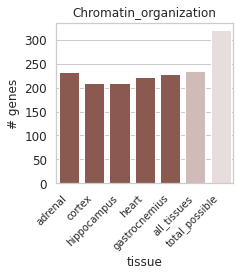

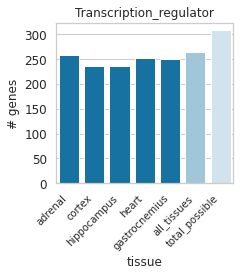

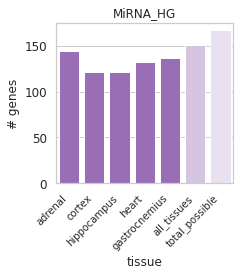

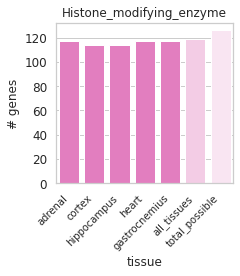

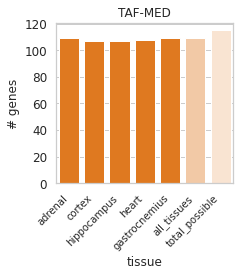

In [48]:
desired_tissue_order = ['adrenal', 'cortex', 'hippocampus', 'heart', 'gastrocnemius', 'all_tissues', 'total_possible']

sns.set(style="whitegrid")

for biotype in all_expr_reg['biotype'].cat.categories:
    subset_data = all_expr_reg[all_expr_reg['biotype'] == biotype]
    
    plot_numbers = subset_data['tissue'].value_counts().reset_index()
    plot_numbers.columns = ['tissue', 'n_genes']
    plot_numbers.loc[len(plot_numbers)] = ['all_tissues', subset_data['gene_name'].nunique()]
    plot_numbers.loc[len(plot_numbers)] = ['total_possible', biotype_totals[biotype]]

    plot_numbers['tissue'] = pd.Categorical(plot_numbers['tissue'], categories=desired_tissue_order)
    
    # Get the color for the current biotype
    biotype_colors = tissue_biotype_palette[biotype]
    
    # Create bar plot with different colors for each bar
    plt.figure(figsize=(3.5, 4))
    plot = sns.barplot(x='tissue', y='n_genes', data=plot_numbers, order=desired_tissue_order, palette=[biotype_colors[tissue] for tissue in desired_tissue_order])
    plt.title(f"{biotype}")
    plt.ylabel("# genes")
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    filename = f"fig2_{biotype}_bulk_barplot.png"
    plt.savefig(f"fig2/{filename}", dpi = 1200)
    
    plt.close()

    


In [49]:
desired_tissue_order = ['adrenal', 'cortex', 'hippocampus', 'heart', 'gastrocnemius', 'all_tissues', 'total_possible']

sns.set(style="whitegrid")

# Iterate over biotypes and letters a to g
for biotype, panel in zip(all_expr_reg['biotype'].cat.categories, string.ascii_lowercase[:7]):
    subset_data = all_expr_reg[all_expr_reg['biotype'] == biotype]
    
    plot_numbers = subset_data['tissue'].value_counts().reset_index()
    plot_numbers.columns = ['tissue', 'n_genes']
    plot_numbers.loc[len(plot_numbers)] = ['all_tissues', subset_data['gene_name'].nunique()]
    plot_numbers.loc[len(plot_numbers)] = ['total_possible', biotype_totals[biotype]]

    plot_numbers['tissue'] = pd.Categorical(plot_numbers['tissue'], categories=desired_tissue_order)
    
    # Get the color for the current biotype
    biotype_colors = tissue_biotype_palette[biotype]
    
    # Create bar plot with different colors for each bar
    plt.figure(figsize=(3.5, 4))
    plot = sns.barplot(x='tissue', y='n_genes', data=plot_numbers, order=desired_tissue_order, palette=[biotype_colors[tissue] for tissue in desired_tissue_order])
    plt.title(f"{biotype}")
    plt.ylabel("# genes")
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    filename = f"fig2{panel}_{biotype}_bulk_barplot.png"
    plt.savefig(f"fig2/{filename}", dpi=1200)
    
    plt.close()


# Fig. 2h

In [12]:
analysis_top_model = Topyfic.read_analysis("../snrna/hippocampus/topyfic/analysis_10x_hipp_13_parse_hipp_12.p")


Reading Analysis done!


In [13]:
row_color = analysis_top_model.cell_participation.obs[['celltypes', 'subtypes']]
row_color.drop_duplicates(inplace=True)
row_color.reset_index(drop=True, inplace=True)

In [14]:
row_color = analysis_top_model.cell_participation.obs[['celltypes', 'subtypes']]
row_color.drop_duplicates(inplace=True)
row_color.reset_index(drop=True, inplace=True)
col = ['Glutamatergic',
       'GABAergic',
       'OPC',
       'Oligodendrocyte',
       'Astrocyte',
       'Microglia',
       'Endothelial',
       'VLMC',
       'Pericyte',
       'Ependymal']



row_color.celltypes = pd.Categorical(row_color.celltypes, categories=col)
row_color.sort_values(by='celltypes', axis=0, inplace=True)
row_color.reset_index(drop=True, inplace=True)
row_color.subtypes = pd.Categorical(row_color.subtypes, categories=[
                                                                    'DG',
                                                                    'DG_early',
                                                                    'CA1',
                                                                    'CA3',
                                                                    'L2/3',
                                                                    'L5/6',
                                                                    'SUB_ProS',
                                                                    'CR',
                                                                    'Glut_other',
                                                                    'Sst',
                                                                    'Vip',
                                                                    'Pvalb',
                                                                    'Lamp5',
                                                                    'Meis2',
                                                                    'OPC',
                                                                    'MFOL',
                                                                    'MOL',
                                                                    'Astrocyte',
                                                                    'Microglia',
                                                                    'Endothelial',
                                                                    'VLMC',
                                                                    'Pericyte',
                                                                    'Ependymal'
                                                                   ])

color = pd.read_csv("../snrna/ref/enc4_mouse_snrna_celltypes.csv")
row_color['color'] = ""
for i in range(row_color.shape[0]):
    tmp = color.celltype_color[color.celltypes == row_color.loc[i, 'celltypes']].values
    row_color.loc[i, 'color'] = tmp[0]

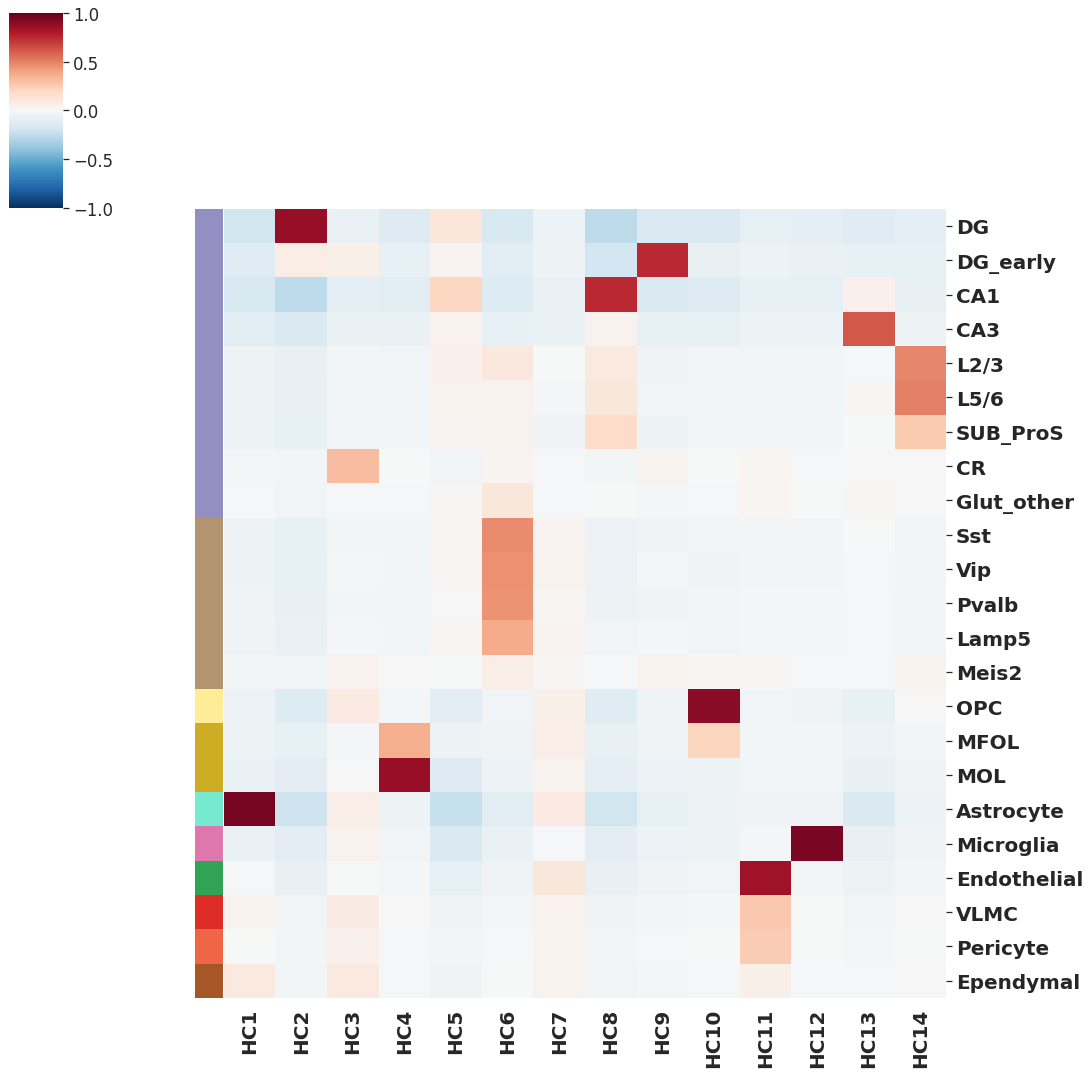

In [15]:
datTraits = Topyfic.Analysis.convertDatTraits(analysis_top_model.cell_participation.obs[['subtypes']])

topicsTraitCor = pd.DataFrame(index=analysis_top_model.cell_participation.to_df().columns,
                                      columns=datTraits.columns,
                                      dtype="float")
topicsTraitPvalue = pd.DataFrame(index=analysis_top_model.cell_participation.to_df().columns,
                                         columns=datTraits.columns,
                                         dtype="float")

for i in analysis_top_model.cell_participation.to_df().columns:
    for j in datTraits.columns:
        tmp = stats.pearsonr(analysis_top_model.cell_participation.to_df()[i], datTraits[j], alternative='greater')
        topicsTraitCor.loc[i, j] = tmp[0]
        topicsTraitPvalue.loc[i, j] = tmp[1]

topicsTraitCor = topicsTraitCor.T
topicsTraitCor.index = pd.CategoricalIndex(topicsTraitCor.index, categories=row_color.subtypes.values)
topicsTraitCor.sort_index(level=0, inplace=True)

xlabels = [f"HC{i+1}" for i in range(analysis_top_model.cell_participation.shape[1])]
ylabels = topicsTraitCor.index

sns.set(font_scale=1.5)
res = sns.clustermap(topicsTraitCor, row_colors=row_color['color'].tolist(), cmap='RdBu_r', 
                          vmin=-1, vmax=1, annot_kws={'size': 20, "weight": "bold"},
                          xticklabels=xlabels, yticklabels=ylabels,
                    figsize=(15,15),
                    col_cluster=False, row_cluster=False)
res.ax_heatmap.axes.set_xticklabels(res.ax_heatmap.axes.get_xmajorticklabels(), fontsize=20, fontweight="bold", rotation=90)
res.ax_heatmap.axes.set_yticklabels(res.ax_heatmap.axes.get_ymajorticklabels(), fontsize=20, fontweight="bold")
plt.yticks(rotation=0)
#ax.set_facecolor('white')

file_name = "fig2/fig2h_topictraithmap_hippocampus"

plt.savefig(file_name, bbox_inches='tight')
plt.show()

# Fig. 2i

In [29]:
metadata = pd.read_csv("../snrna/hippocampus/seurat/hippocampus_Parse_10x_integrated_metadata.csv")
analysis_top_model = Topyfic.read_analysis("../snrna/hippocampus/topyfic/analysis_10x_hipp_13_parse_hipp_12.p")

tech_palette = {'Parse': '#801b73',
                  '10x': '#00a1df'}

norm = mpl.colors.Normalize(vmin=metadata['monocle3_pseudotime'].min(), 
                            vmax=metadata['monocle3_pseudotime'].max())
monocle3_palette = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')

my_palette = {'monocle3_pseudotime': monocle3_palette,
              'timepoint' : tp_palette,
              'sex': sex_palette,
              'technology': tech_palette}

analysis_top_model.colors_topics.index = [f"HC{i+1}" for i in range(analysis_top_model.colors_topics.shape[0])]
analysis_top_model.cell_participation.var.index = [f"HC{i+1}" for i in range(analysis_top_model.cell_participation.shape[1])]

colors = sns.color_palette("gray", 30).as_hex()


Reading Analysis done!


In [30]:
j = 19
for i in range(analysis_top_model.colors_topics.shape[0]):
    if analysis_top_model.colors_topics.index[i] not in ["HC10", 
                                                         "HC5", 
                                                         "HC7",
                                                         "HC4"]:
        analysis_top_model.colors_topics.colors[i] = colors[j]
        j = j - 1
        
analysis_top_model.colors_topics.colors["HC10"] = "#00f77b"
analysis_top_model.colors_topics.colors["HC5"] = "#00c5e3"
analysis_top_model.colors_topics.colors["HC7"] = "#f05c13"
analysis_top_model.colors_topics.colors["HC4"] = "#ffbc25"



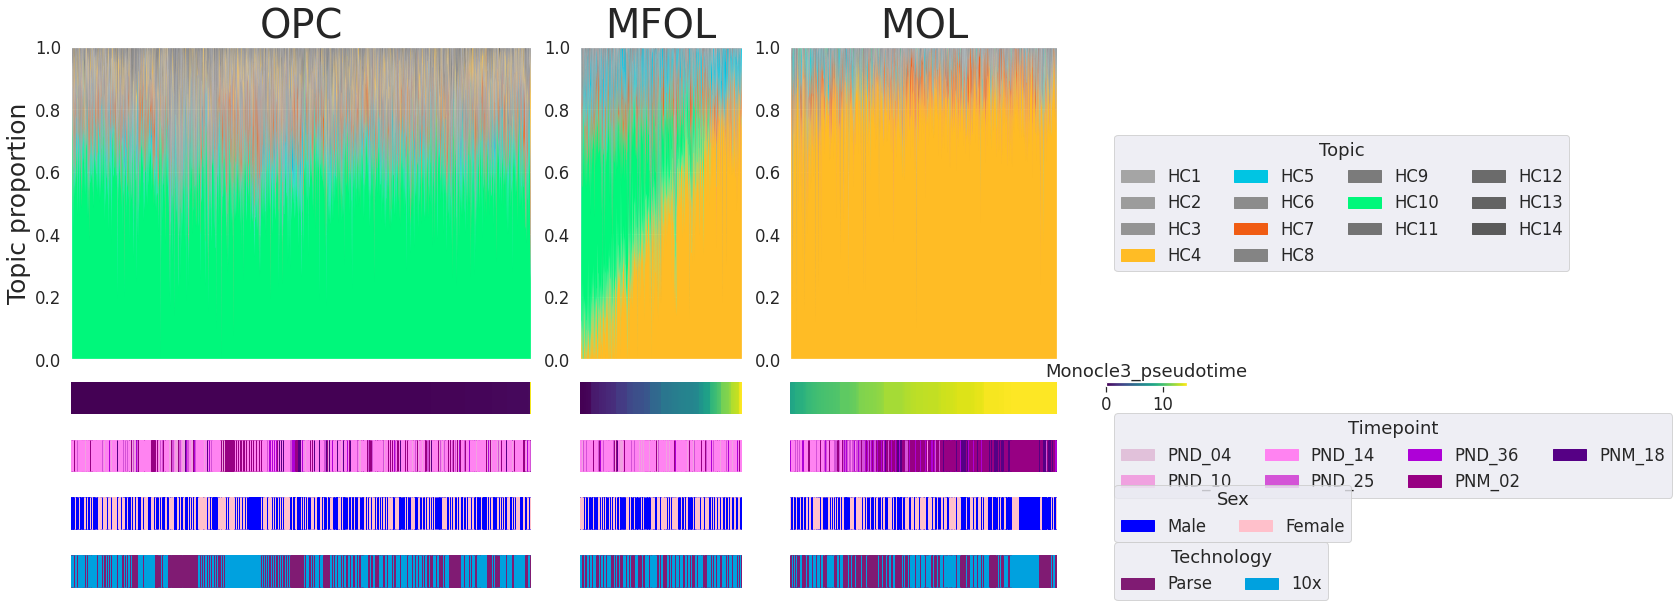

In [31]:
subtypes = ['OPC', 'MFOL','MOL']
file_name = "fig2/fig2i_opc_oligo_structure"
analysis_top_model.structure_plot(level='subtypes',
                                  category=subtypes,
                                  metaData=["monocle3_pseudotime","timepoint", "sex", "technology"], #"",
                                  metaData_palette=my_palette,
                                  order_cells=["monocle3_pseudotime"],
                                  figsize = (20, 10),
                                  save=True,
                                  show=True,
                                  file_format='pdf',
                                  file_name=file_name)


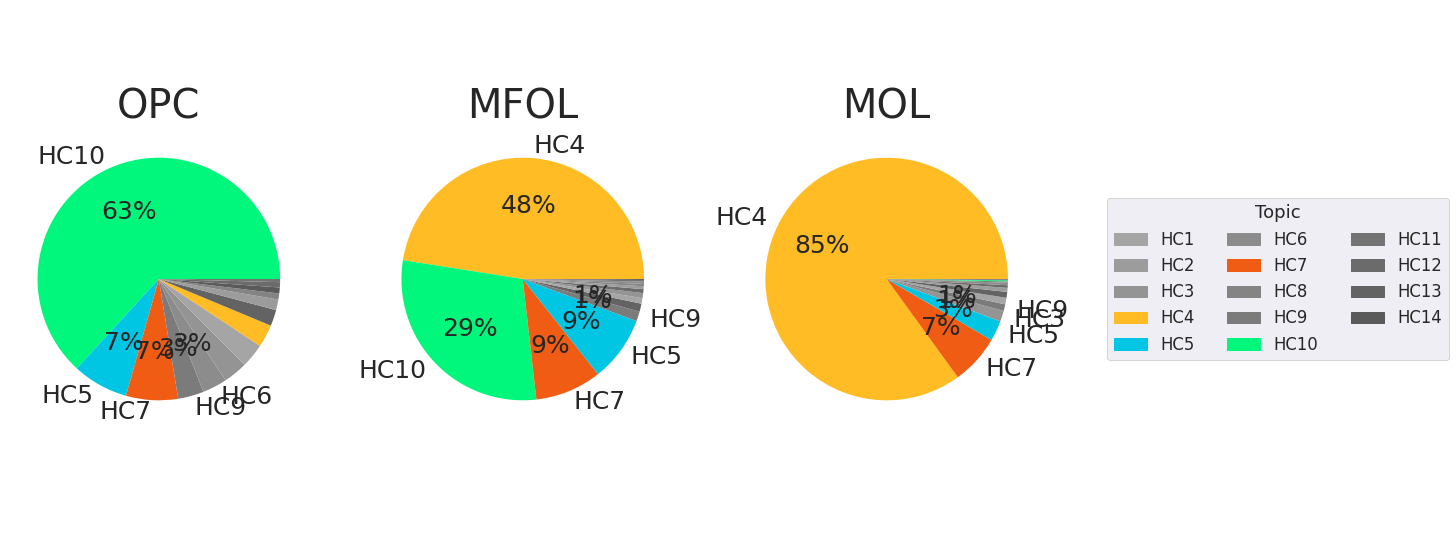

In [32]:
subtypes = ['OPC', 'MFOL','MOL']
file_name = "fig2/fig2i_opc_oligo_pie"
analysis_top_model.pie_structure_Chart(level='subtypes',
                                       category=subtypes,
                                       figsize = (25, 10),
                                       save=True,
                                       show=True,
                                       file_format='pdf',
                                       file_name=file_name)

In [33]:
j = 19
for i in range(analysis_top_model.colors_topics.shape[0]):
    if analysis_top_model.colors_topics.index[i] not in ["HC9", "HC2", "HC5"]:
        analysis_top_model.colors_topics.colors[i] = colors[j]
        j = j - 1
        
analysis_top_model.colors_topics.colors["HC9"] = "#00fe35"
analysis_top_model.colors_topics.colors["HC2"] = "#3c41ab"
analysis_top_model.colors_topics.colors["HC5"] = "#00c5e3"



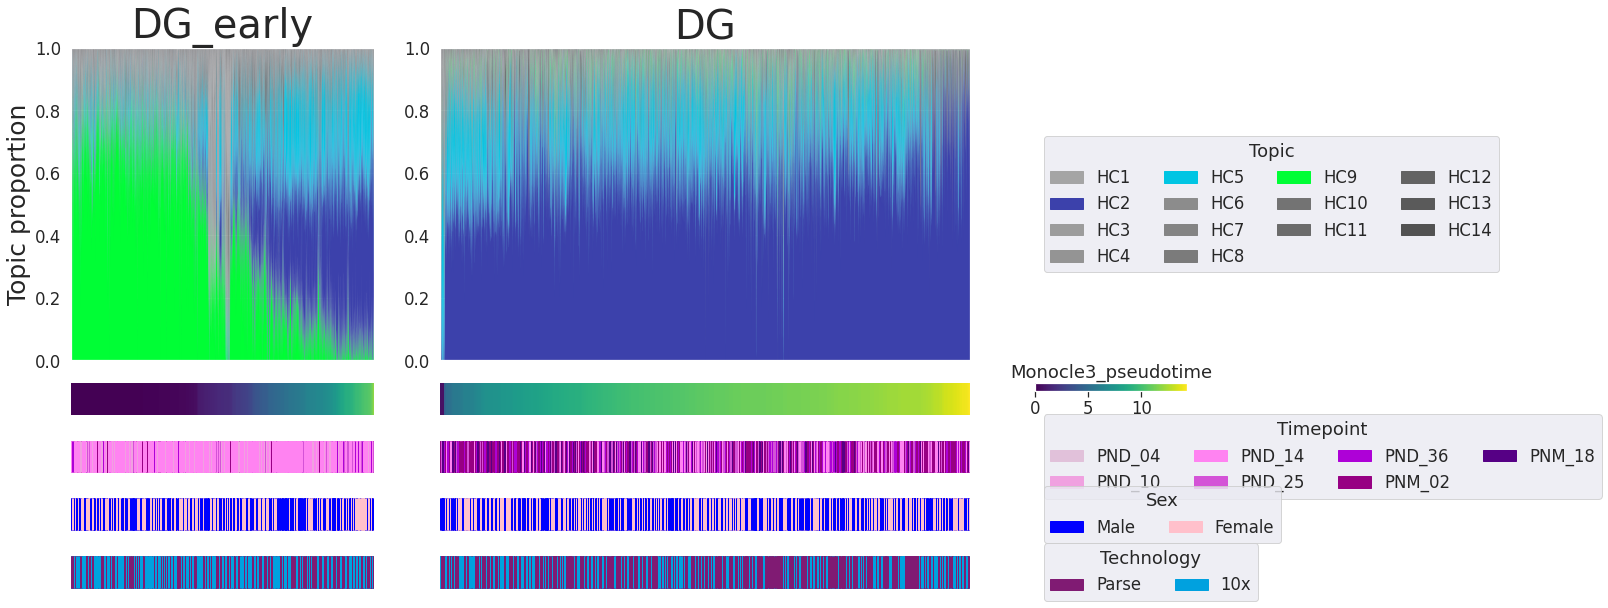

In [34]:
subtypes = ['DG_early', 'DG']
file_name = "fig2/fig2j_dg_structure"
analysis_top_model.structure_plot(level='subtypes',
                                  category=subtypes,
                                  metaData=["monocle3_pseudotime","timepoint", "sex", "technology"], #"",
                                  metaData_palette=my_palette,
                                  order_cells=["monocle3_pseudotime"],
                                  figsize = (20, 10),
                                  save=True,
                                  show=True,
                                  file_format='pdf',
                                  file_name=file_name)


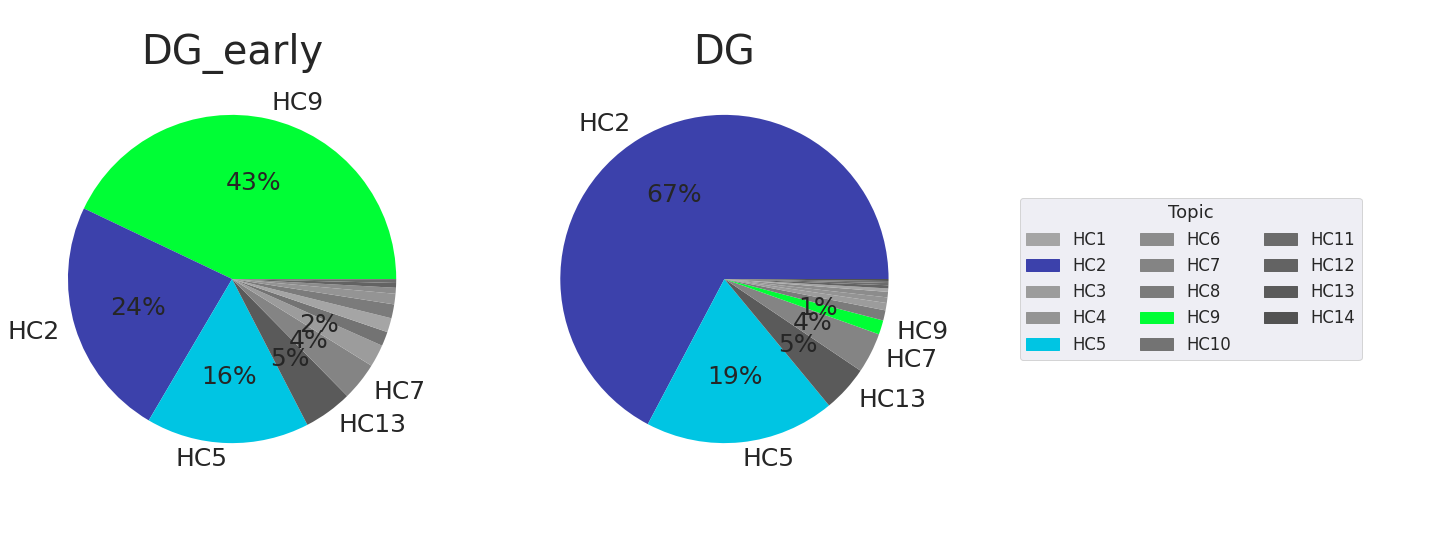

In [35]:
subtypes = ['DG_early', 'DG']
file_name = "fig2/fig2j_dg_pie"

analysis_top_model.pie_structure_Chart(level='subtypes',
                                       category=subtypes,
                                       figsize = (25, 10),
                                       save=True,
                                       show=True,
                                       file_format='pdf',
                                       file_name=file_name)